In [1]:
from catalogue import *

Using TensorFlow backend.


In [2]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)


In [3]:
inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.3 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r'])


a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

print "Number of stars after colour cut:", inputs.shape[0]

Number of stars after colour cut: 132156


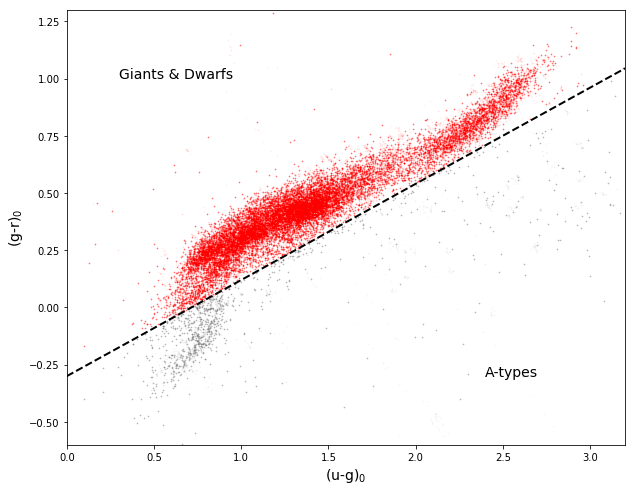

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(inputs['u-g'], inputs['g-r'], s=0.5, c="red",alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
plt.scatter(a_star['u-g'], a_star['g-r'], s=0.5, c='grey',alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
line=np.arange(0.0,3.5,0.002)
plt.plot(line,0.42*line-0.3,"k--",lw=2)
plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)
plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/color_color_ML.pdf", format='pdf')
plt.show()

In [5]:
# Apply the color cuts for machine learning 
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

input_forML2 = inputs[ml_cut]
output_forML2 = outputs[ml_cut]
error_forML2 = error[ml_cut]

logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

input_finalML2 = input_forML2[logg_cut].reset_index(drop=True)
output_finalML2 = output_forML2[logg_cut].reset_index(drop=True)
error_finalML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_finalML2['logg_binary'] = np.where(output_finalML2['logg'] > 3.5, 'dwarf', 'giant')

def classify_logg(val):
    if val >= 4.:
        return 2
    elif val < 4. and val > 3.:
        return 1
    else:
        return 0
    
output_finalML2['logg_trinary'] = output_finalML2.apply(lambda x: classify_logg(x['logg']), axis=1)

print "Number of stars after machine learning cuts in u-i, and g-z:", input_finalML2.shape[0]

Number of stars after machine learning cuts in u-i, and g-z: 76721


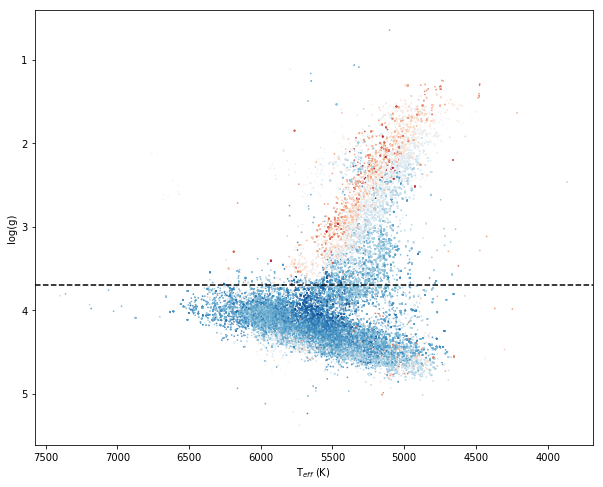

In [6]:
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(output_finalML2['Teff'].values, output_finalML2['logg'].values, s=0.5,rasterized=True, c=output_finalML2['feh'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [7]:
###########
# Need to keep all these transformation => you should make the transformation subroutine
###########

colour_mean_logg = [input_finalML2[key].describe()['mean'] for key in input_finalML2]
colour_std_logg = [input_finalML2[key].describe()['std'] for key in input_finalML2]

mean_logg = output_finalML2['logg'].describe()['mean']
std_logg = output_finalML2['logg'].describe()['std']

error_logg_min=error_finalML2['dlogg'].describe()['min']
error_logg_max=error_finalML2['dlogg'].describe()['max']

stats_array = (input_finalML2, output_finalML2, error_finalML2)

# write final input and output dataframes to pickle file to load externally
with open('./pickle/stats_summary.pickle', 'r+') as f:
    pickle.dump(stats_array, f)

input_finalML2.sample(frac=1) # randomly shuffle order of pandas dataframe

# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(input_finalML2)
outputf = normalize(output_finalML2)
errorf = normalize(error_finalML2, 'min_max')

inputf_train = inputf.sample(frac=0.8, random_state=99)
inputf_test = inputf.loc[~inputf.index.isin(inputf_train.index), :]

outputf_train = outputf.sample(frac=0.8, random_state=99)
outputf_test = outputf.loc[~outputf.index.isin(outputf_train.index), :]

errorf_train = errorf.sample(frac=0.8, random_state=99)
errorf_test = outputf.loc[~errorf.index.isin(errorf_train.index), :]

train_frac = inputf_train.shape[0]/float(inputf.shape[0])
test_frac = inputf_test.shape[0]/float(inputf.shape[0])


print "Fraction of data for training:", train_frac
print "Fraction of data for testing:", test_frac
print "Check total is always 1.0:", train_frac+test_frac

Fraction of data for training: 0.800002606848
Fraction of data for testing: 0.199997393152
Check total is always 1.0: 1.0


In [8]:
x_train = inputf_train
y_train = outputf_train['logg_binary']

x_test = inputf_test
y_test = outputf_test['logg_binary']

x_error = errorf_test
y_error = errorf_train['dlogg']

In [9]:
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(x_train, y_train)
preds = gnb.predict(x_test)
# Evaluate accuracy
print "Accuracy", accuracy_score(y_test, preds)

Accuracy 0.787604275286757


In [10]:
# Make data to train on colours
inputs_col = pd.DataFrame()
#u-g,g-r,r-i,i-z
inputs_col['u-g']=inputf['u']-inputf['g']
inputs_col['g-r']=inputf['g']-inputf['r']
inputs_col['r-i']=inputf['r']-inputf['i']
inputs_col['i-z']=inputf['i']-inputf['z']
inputs_col['z-y']=inputf['z']-inputf['y']
inputs_col['u-G']=inputf['u']-inputf['G']
inputs_col['u-RP']=inputf['u']-inputf['RP']
inputs_col['u-BP']=inputf['u']-inputf['BP']

## To do:
----
1. Create binary classification scheme for A-type vs. non A-type stars. Put on hold for now...
2. Create loss vs. epoch plots for stratified k-fold binary classifier [x]
3. Plot Teff vs. logg to show how well the classifier works. 
4. Save the model and use it on the globular cluster catalogues. [x]

In [11]:
seed = 7
np.random.seed(seed)

X = inputs_col.values.astype(float)
Y = outputf['logg_trinary'].values
# loading the iris dataset
print X.shape, Y.shape
 
# X -> features, y -> label
y = Y
print Y

(76721, 8) (76721,)
[2 2 1 ... 1 0 2]


In [12]:
epochs=150
batch_size =1000

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=8, kernel_initializer='normal', activation='relu')) #input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

new_model = False

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=1)

if new_model:
    # evaluate model with standardized dataset
    print "Baseline creation..."
    y_pred = cross_val_predict(estimator, X, encoded_Y, cv=kfold, n_jobs = 3)
    y_val = (y_pred, encoded_Y)
    pickle.dump(y_val, open( "./pickle/binary_class_pred.pickle", "wb" ) )

else:
    y_val = pickle.load(open( "./pickle/binary_class_pred.pickle", "rb" ))

In [13]:
conf_mat = confusion_matrix(encoded_Y, y_pred)
y_true = pd.Series(outputf['logg_binary'])
y_predicted = encoder.inverse_transform(y_pred[:,0])
y_prd = pd.Series(y_predicted)

display(pd.crosstab(y_true, y_prd, rownames=['True'], colnames=['Predicted'], margins=True))
#cm = confusion_matrix(y_true, y_prd)
cm = conf_mat

tp0, fn, fp, tp1 = map(float, cm.ravel())

tp = tp0+tp1
precision = tp/(tp+fp)
accuracy = (tp0+tp1)/ (tp0+tp1+fn+fp)
recall = tp/(tp+fn)
recall_1 = tp0/(tp0+fn)
recall_2 = tp1/(tp1+fn)
F1 = 2*(recall * precision) / (recall + precision)
completeness = tp0/(tp0+fp)
purity = tp1/(tp1+fp)
print "Accuracy:", accuracy
print "Precision:", precision
print "Recall:",recall, recall_1, recall_2
print "F1:", F1
print "Completeness:", completeness
print "Purity:", purity

NameError: name 'y_pred' is not defined

In [14]:
y_pred = y_val[0]
#encoded_Y = y_val[1] 
do_again = False

if do_again:
    test_loss, test_acc, train_loss, train_acc = [], [], [], []

    for train, test in kfold.split(inputs_col.values, encoded_Y):
        history = estimator.fit(inputs_col.values[train], encoded_Y[train], validation_data=(inputs_col.values[test], encoded_Y[test]), epochs=250, batch_size=1000, verbose=1)

        test_loss.append(history.history['val_loss'])
        test_acc.append(history.history['val_acc'])
        train_acc.append(history.history['acc'])
        train_loss.append(history.history['loss'])

    test_loss = np.asarray(test_loss)
    test_acc = np.asarray(test_acc)
    train_loss = np.asarray(train_loss)
    train_acc = np.asarray(train_acc)

    pickle.dump((test_loss, test_acc, train_acc, train_loss), open( "./pickle/500_epochs_3rd_col.pickle", "wb" ) )

test_loss, test_acc, train_acc, train_loss = pickle.load(open('./pickle/500_epochs_3rd_col.pickle', 'rb'))

test_loss_max = np.amax(test_loss, axis=0)
test_loss_min = np.amin(test_loss, axis=0)
train_loss_max = np.amax(train_loss, axis=0)
train_loss_min = np.amin(train_loss, axis=0)

test_acc_max = np.amax(test_acc, axis=0)
test_acc_min = np.amin(test_acc, axis=0)
train_acc_max = np.amax(train_acc, axis=0)
train_acc_min = np.amin(train_acc, axis=0)

IOError: [Errno 2] No such file or directory: './pickle/500_epochs_3rd_col.pickle'

NameError: name 'test_acc_max' is not defined

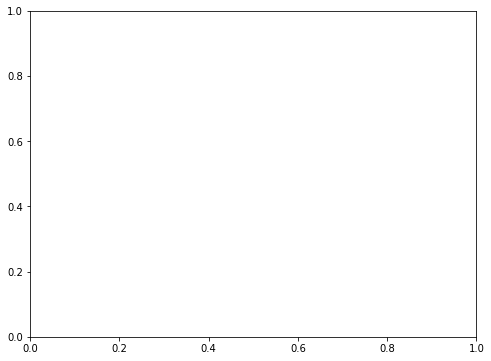

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

#ax.set_yscale('log')
#ax.plot(range(0,len(test_acc_max)), test_acc_min, '--', color='red')
#ax.plot(range(0,len(train_acc_max)), train_acc_min, '--', color='blue')
ax.fill_between(range(0,len(test_acc_max)), test_acc_min, test_acc_max, alpha=0.5, color='red')
ax.fill_between(range(0,len(train_acc_max)), train_acc_min, train_acc_max, alpha=0.5)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./plots/model_acc_3rd_col')

fig, ax = plt.subplots(figsize=(8, 6))

#ax.set_yscale('log')
ax.fill_between(range(0,len(test_loss_max)), test_loss_min, test_loss_max, alpha=0.5, color='red')
ax.fill_between(range(0,len(train_loss_max)), train_loss_min, train_loss_max, alpha=0.5)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('./plots/model_loss_3rd_col') 

In [16]:
estimator.fit(X, encoded_Y, epochs=50, batch_size=1000, verbose=1)

Epoch 1/50
76721/76721 [==============================] - 6s 72us/step - loss: 0.4456 - acc: 0.8147: 1s - los
Epoch 2/50
76721/76721 [==============================] - 5s 65us/step - loss: 0.3084 - acc: 0.8688
Epoch 3/50
76721/76721 [==============================] - 5s 66us/step - loss: 0.2893 - acc: 0.8762
Epoch 4/50
76721/76721 [==============================] - 5s 65us/step - loss: 0.2819 - acc: 0.8781
Epoch 5/50
76721/76721 [==============================] - 5s 66us/step - loss: 0.2771 - acc: 0.8808
Epoch 6/50
76721/76721 [==============================] - 5s 66us/step - loss: 0.2743 - acc: 0.8821
Epoch 7/50
76721/76721 [==============================] - 5s 68us/step - loss: 0.2727 - acc: 0.8828
Epoch 8/50
76721/76721 [==============================] - 5s 63us/step - loss: 0.2704 - acc: 0.8835
Epoch 9/50
76721/76721 [==============================] - 5s 66us/step - loss: 0.2674 - acc: 0.8852
Epoch 10/50
76721/76721 [==============================] - 5s 66us/step - loss: 0.2629 - a

In [16]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = estimator.model.to_json()


with open("./models/2nd_col/model_num_3rd_A_col.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
estimator.model.save_weights("./models/2nd_col/model_num_3rd_A_col.h5")

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(encoded_Y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

'''
history = y_pred#estimator.fit(X, Y, validation_split=0.33, epochs=100, batch_size=1000, verbose=1)          
print history.history.keys() 
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()'''

In [ ]:
outputf['class_pred'] = y_pred
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(outputf['Teff'].values, outputf['logg'].values, s=0.5,rasterized=True, c=outputf['class_pred'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import seaborn as sns  

correlation = df_original.corr()  
plt.figure(figsize=(25, 25))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig('correlation.pdf')

In [ ]:
#history = model.fit(X, Y, validation_split=0.33, epochs=500, batch_size=1000, verbose=1)          
print history.history.keys() 
plt.figure(figsize=(10, 8))
# summarize history for accuracy
plt.semilogy(history.history['acc'])
plt.semilogy(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 8))

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# importing necessary libraries
 
# loading the iris dataset
print X.shape, Y.shape
 
# X -> features, y -> label
y = Y
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
 
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11).fit(X_train, y_train)
 
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print accuracy

print np.sqrt(len(Y))
 
# creating a confusion matrix
knn_predictions = knn.predict(X_test) 
cm = confusion_matrix(y_test, knn_predictions)

y_true = pd.Series(y_test)
y_pred = pd.Series(knn_predictions)

display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

#2*TP /(2*TP + FP + FN)
print "F1, 0", 2.*cm[0,0]/(np.sum(cm[0,:])+np.sum(cm[:,0]))
print "F1, 1", 2.*cm[1,1]/(np.sum(cm[1,:])+np.sum(cm[:,1]))
print "F1, 2", 2.*cm[2,2]/(np.sum(cm[2,:])+np.sum(cm[:,2])

### Make colour colour plots to find out what the overfitting looks like at low k values
### TNSE


# 